In [3]:
from pathlib import Path
import subprocess
from concurrent.futures import ThreadPoolExecutor

def process_l3_image(files, output_dir):
    print(f"Processing L3 image: {[Path(file).name for file in files]}")
    cmd = [
        "python",
        "l3_processor/l3_merge.py",
        str(files[0]),
        str(files[1]),
        str(files[2]),
        "--coalign",
        "--outdir",
        str(output_dir),
    ]
    print(" ".join(cmd))
    result = subprocess.run(cmd, check=True, shell=True)
    return result

def group_l2_files(files):
    groups = {}
    for file in files:
        file_stem = Path(file).stem
        key = file_stem.split("_")[-2][:-2]  # remove last character to group
        if key not in groups:
            groups[key] = []
        groups[key].append(file)
    return groups

In [4]:
# ***************** Input images *******************
files = list(Path('Y:/06_SpaceStuff/Spacecraft/Proba3/processed/Orbit273/').glob('aspiics_wb_l2_*.fits'))
files.sort()

# files = [
#     "Y:/06_SpaceStuff/Spacecraft/Proba3/processed/Orbit273/aspiics_wb_l2_11108000000212_20250716T163537.fits",
#     "Y:/06_SpaceStuff/Spacecraft/Proba3/processed/Orbit273/aspiics_wb_l2_11108000000213_20250716T163538.fits",
#     "Y:/06_SpaceStuff/Spacecraft/Proba3/processed/Orbit273/aspiics_wb_l2_11108000000211_20250716T163536.fits",
# ]

# group files by name pattern (assuming 3 files per group) eg. aspiics_wb_l2_1110800000021*

groups = group_l2_files(files)

print(f"Found {len(groups)} groups of L2 files to process.")

# for group in groups.values():
#     if len(group) == 3:
#         process_l3_image(
#             group,
#             Path("Y:/06_SpaceStuff/Spacecraft/Proba3/processed/Orbit273/L3"),
#         )
#     else:
#         print(f"Skipping group with {len(group)} files: {group}")


# Alternatively, to process images in parallel using threads:
threads = 8
with ThreadPoolExecutor(max_workers=threads) as executor:
    futures = [executor.submit(process_l3_image, group, Path("Y:/06_SpaceStuff/Spacecraft/Proba3/processed/Orbit273/L3")) for group in groups.values() if len(group) == 3]
    for future in futures:
        future.result()  # to catch exceptions if any


Found 186 groups of L2 files to process.
Processing L3 image: ['aspiics_wb_l2_11108000000111_20250716T163506.fits', 'aspiics_wb_l2_11108000000112_20250716T163507.fits', 'aspiics_wb_l2_11108000000113_20250716T163508.fits']
python l3_processor/l3_merge.py Y:\06_SpaceStuff\Spacecraft\Proba3\processed\Orbit273\aspiics_wb_l2_11108000000111_20250716T163506.fits Y:\06_SpaceStuff\Spacecraft\Proba3\processed\Orbit273\aspiics_wb_l2_11108000000112_20250716T163507.fits Y:\06_SpaceStuff\Spacecraft\Proba3\processed\Orbit273\aspiics_wb_l2_11108000000113_20250716T163508.fits --coalign --outdir Y:\06_SpaceStuff\Spacecraft\Proba3\processed\Orbit273\L3
Processing L3 image: ['aspiics_wb_l2_11108000000211_20250716T163536.fits', 'aspiics_wb_l2_11108000000212_20250716T163537.fits', 'aspiics_wb_l2_11108000000213_20250716T163538.fits']
python l3_processor/l3_merge.py Y:\06_SpaceStuff\Spacecraft\Proba3\processed\Orbit273\aspiics_wb_l2_11108000000211_20250716T163536.fits Y:\06_SpaceStuff\Spacecraft\Proba3\proces

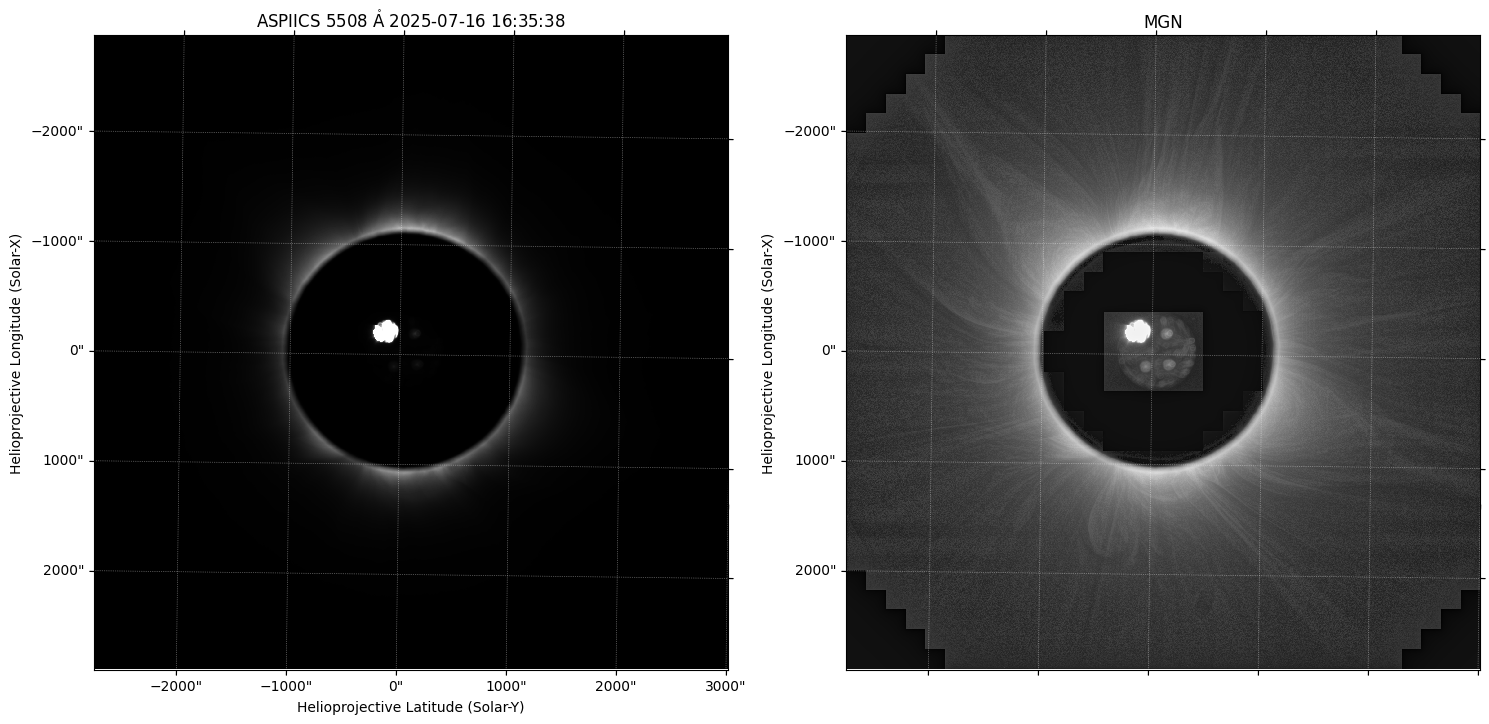

In [7]:
import matplotlib.pyplot as plt

from astropy import units as u

import sunpy.map

import numpy as np

import sunkit_image.enhance as enhance


###########################################################################
# aspiics_map = sunpy.map.Map("Y:/06_SpaceStuff/Spacecraft/Proba3/processed/Orbit273/lintestorig/aspiics_wb_l3_11108000000213_20250716T163538.merged.fits")
aspiics_map = sunpy.map.Map("y:/06_SpaceStuff/Spacecraft/Proba3/processed/Orbit273/L3/aspiics_wb_l3_11108000000213_20250716T163538.merged.fits")

aspiics_map = sunpy.map.Map(np.clip(np.nan_to_num(aspiics_map.data, nan=0.0), 0, 0.000002), aspiics_map.meta)

###########################################################################
# Applying Multi-scale Gaussian Normalization on a solar image.
#
# The `sunkit_image.enhance.mgn` function takes either a `sunpy.map.Map` or a `numpy.ndarray` as a input.

mgn_map = enhance.mgn(aspiics_map, h=0.95, sigma=[1.25, 2.5, 5, 10, 20, 40, 80], k=0.7, gamma=3.5, weights=[1, 1, 1, 1.5, 1.5, 2, 2])

###########################################################################
# Finally we will plot the filtered maps with the original to demonstrate the effect.

fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(121, projection=aspiics_map)
aspiics_map.plot(axes=ax, clip_interval=(1, 99.99) * u.percent)

ax1 = fig.add_subplot(122, projection=mgn_map)
mgn_map.plot(axes=ax1)
ax1.set_title("MGN")

ax1.coords[1].set_ticklabel_visible(False)
fig.tight_layout()

plt.show()

In [35]:
import matplotlib.pyplot as plt

from astropy import units as u

import sunpy.map

import numpy as np

import sunkit_image.enhance as enhance

def MGN_enhance(aspiics_map, plot=False):
    aspiics_map = sunpy.map.Map(np.clip(np.nan_to_num(aspiics_map.data, nan=0.0), 0, 0.000002), aspiics_map.meta)

    ###########################################################################
    # Applying Multi-scale Gaussian Normalization on a solar image.
    #
    # The `sunkit_image.enhance.mgn` function takes either a `sunpy.map.Map` or a `numpy.ndarray` as a input.

    # from Jhelioviewer
    # private static final int K = 3;
    # private static final float MIX_FACTOR = 0.97f;
    # private static final float ONE_MINUS_MIX_FACTOR = 1f - MIX_FACTOR;
    # private static final float[] sigmas = {1, 4, 16, 64};
    # private static final float[] weights = {0.125f, 0.25f, 0.5f, 1f};

    #apply gamma 2.2 
    # aspiics_map = sunpy.map.Map(aspiics_map.data ** (1/2.2), aspiics_map.meta)
    # mgn_map = enhance.mgn(aspiics_map, h=0.97, sigma=[1, 4, 16, 64], k=3, weights=[0.125, 0.25, 0.5, 1], gamma=1 )

    mgn_map = enhance.mgn(aspiics_map, h=0.85, sigma=[1, 4, 16, 64], k=1, weights=[0.125, 0.25, 0.5, 1], gamma=3.2 )
    # mgn_map = enhance.mgn(aspiics_map, h=0.9, sigma=[1.25, 2.5, 5, 10, 20, 40, 80, 160], k=0.7, weights=[1, 1, 1, 1.5, 1.5, 2, 2, 2], gamma=1.5 )

    if plot:
        ###########################################################################
        # Finally we will plot the filtered maps with the original to demonstrate the effect.

        fig = plt.figure(figsize=(15, 10))

        ax = fig.add_subplot(121, projection=aspiics_map)
        aspiics_map.plot(axes=ax, clip_interval=(1, 99.99) * u.percent)

        ax1 = fig.add_subplot(122, projection=mgn_map)
        mgn_map.plot(axes=ax1)
        ax1.set_title("MGN")

        ax1.coords[1].set_ticklabel_visible(False)
        fig.tight_layout()

        plt.show()
    
    return mgn_map



###########################################################################
files = list(Path('Y:/06_SpaceStuff/Spacecraft/Proba3/processed/Orbit273/L3/').glob('aspiics_wb_l3_*.fits'))
files.sort()

# aspiics_map = sunpy.map.Map("Y:/06_SpaceStuff/Spacecraft/Proba3/processed/Orbit273/lintestorig/aspiics_wb_l3_11108000000213_20250716T163538.merged.fits")
# aspiics_map = sunpy.map.Map("y:/06_SpaceStuff/Spacecraft/Proba3/processed/Orbit273/L3/aspiics_bt_l3_111080000002_20250716T163536.fits")
# aspiics_map = sunpy.map.Map(files[-1])

def enhance_and_save(file):
    aspiics_map = sunpy.map.Map(file)
    aspiics_map = MGN_enhance(aspiics_map, plot=False)

    # normalize data
    aspiics_data = aspiics_map.data / np.nanmax(aspiics_map.data)
    aspiics_data = np.nan_to_num(np.clip(aspiics_data, 0, 1), nan=0.0)

    # save as tiff
    # plt.imsave(f"Y:/06_SpaceStuff/Spacecraft/Proba3/processed/Orbit273/L3/enhanced/{file.stem}.tiff", np.uint16(aspiics_data * 65535), cmap='gray')

    # save map as fits
    aspiics_map.save(f"Y:/06_SpaceStuff/Spacecraft/Proba3/processed/Orbit273/L3/enhanced/{file.stem}_enhanced.fits")

with ThreadPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(enhance_and_save, file) for file in files]
    for future in futures:
        future.result()  # to catch exceptions if any

        
